# Facebook Prophet Model

In this notebook we will:
- Introduce the Facebook prophet forecast model,
- Demonstrate how to use it in python, and
- Discuss some pitfalls of the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
set_style("whitegrid")

## What is the Facebook Prophet model?

The Facebook Prophet model is a forecasting model developed by Facebook and published in 2018, <a href="Forecasting at Scale.pdf">Forecasting at Scale by Sean J. Taylor and Benjamin Letham</a>. While it has become somewhat less well-regarded due to a very prominent Zillow news story, it is nonetheless a commonly used forecast in industry. It is thus important that you are at least exposed to this model, learn the basics of its use, and are made aware of its shortcomings.

## The model

The Facebook Prophet model takes the following form:

$$
y(t) = g(t) + s(t) + h(t) + \epsilon_t.
$$

Here $y(t)$ is the output variable we are attempting to model, $g(t)$ is a function of $t$ that looks to capture the trend component of the time series, $s(t)$ is a function of $t$ that looks to capture the seasonal component(s) of the time series, $h(t)$ is a function of $t$ that looks to capture holiday effects of the time series, and $\epsilon_t$ is an error term that is assumed to follow a normal distribution.

This formulation is similar to a class of models known as generalized additive models or GAMs, <a href="https://en.wikipedia.org/wiki/Generalized_additive_model">https://en.wikipedia.org/wiki/Generalized_additive_model</a>. We will not dive too far into the details of how this model is fit, but you can always refer to the source article which is linked to above.

### $g(t)$

The prophet model allows for two types of trend function:
1. One that models saturating growth using a modification of the growth function:
$$
\frac{C}{1 + \exp(-k(t-m))}, \text{ and}
$$
2. One that models a linear trend using a modification of:
$$
kt + m.
$$

The main modification of these two functions is the ability to choose <i>changepoints</i>. Changepoints are points in time at which you expect the growth rate may be different. In the model changepoints allow for alterations of the $k$ and $m$ parameters at set times. In the linear example, this produces a piecewise linear function. The paper gives the example of the introduction of a new product from Facebook. You are able to provide these changepoints by hand depending on the problem under consideration.

### $s(t)$

The seasonal aspect of the data are fit with a Fourier series:

$$
 \sum_{n=1}^N \left( a_n \cos \left( \frac{2 \pi n t}{P} \right) + b_n \sin \left( \frac{2 \pi nt}{P} \right) \right),
$$

where $P$ is the suspected period of the time series ($P = 7 \text{ days}$ for a weekly period, $P = 365.25 \text{ days}$ for a yearly period). 

You can select an optimal $N$ with a hyperparameter tuning process. The prophet model allows for <i>multi-seasonality</i>, which is a phenomena in which the time series has seasonal patterns on different timescales. For the prophet model this means yearly, weekly, and daily timescales.

### $h(t)$

Holidays are modeled using a series of indicator functions that check if the observation occurs within a given window of chosen holidays.

While we did not cover how these functions are fit, you can look at the original paper, which is linked to above, for details.

## Fitting a Prophet model in python

You can fit a Prophet model using the `Prophet` model object from the `prophet` package. You will likely need to install this package. Installation instructions can be found here, <a href="https://facebook.github.io/prophet/docs/installation.html#python">https://facebook.github.io/prophet/docs/installation.html#python</a>.

In [2]:
## importing the package and checking the version
import prophet

print(prophet.__version__)

1.0


We will use the model to predict flu cases, let's load that data.

In [3]:
flu = pd.read_csv("../../../data/us_flu_1928_1948.csv",
                  parse_dates = ['date'])


flu_train = flu.iloc[:-110].copy()
flu_test = flu.drop(flu_train.index).copy()

In [4]:
flu_train.head()

,date,year,week,cases
0,1928-01-01,1928,1,2938
1,1928-01-08,1928,2,3343
2,1928-01-15,1928,3,3208
3,1928-01-22,1928,4,3118
4,1928-01-29,1928,5,3743


### Specific column names

One important step in fitting the prophet model is renaming your columns. The `prophet` package requires that your dates be stored in a column labeled `ds` and that your time series of interest be stored in a column labeled `y`. Let's take that cleaning step now.

In [5]:
flu_train = flu_train[['date', 'cases']].rename(columns = {'date':'ds',
                                                           'cases':'y'}).copy()


flu_test = flu_test[['date', 'cases']].rename(columns = {'date':'ds',
                                                           'cases':'y'}).copy()

In [6]:
flu_train.head()

,ds,y
0,1928-01-01,2938
1,1928-01-08,3343
2,1928-01-15,3208
3,1928-01-22,3118
4,1928-01-29,3743


### Fitting an out-of-the-box model

We can now fit the default model. `Prophet` works just like an `sklearn` model object. First you make the model object, then you fit the model, then you can make predictions.

In [7]:
## Importing the model
from prophet import Prophet

In [8]:
## Making the model object
m = Prophet()

## Fitting the model, notice that we just input the df
## no .fit(X, y)
m.fit(flu_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2130.07     0.0029397       67.8338           1           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       2130.23   0.000158324       96.7727   1.745e-06       0.001      215  LS failed, Hessian reset 
     168       2130.23   3.57079e-07       59.1441           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [9]:
## We can get the prediction on the prediction on the 
## training set with m.predict()
forecast = m.predict()

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [10]:
## This produces a dataframe
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1928-01-01,6225.869053,11785.207585,54622.492747,6225.869053,6225.869053,27577.065664,27577.065664,27577.065664,4428.240219,4428.240219,4428.240219,23148.825446,23148.825446,23148.825446,0.0,0.0,0.0,33802.934718
1,1928-01-08,6198.644005,8747.017222,49826.625743,6198.644005,6198.644005,23966.951672,23966.951672,23966.951672,4428.240219,4428.240219,4428.240219,19538.711454,19538.711454,19538.711454,0.0,0.0,0.0,30165.595678
2,1928-01-15,6171.418957,5210.617327,46128.354089,6171.418957,6171.418957,20017.803041,20017.803041,20017.803041,4428.240219,4428.240219,4428.240219,15589.562822,15589.562822,15589.562822,0.0,0.0,0.0,26189.221998
3,1928-01-22,6144.193909,1487.552328,42526.497593,6144.193909,6144.193909,16224.490350,16224.490350,16224.490350,4428.240219,4428.240219,4428.240219,11796.250131,11796.250131,11796.250131,0.0,0.0,0.0,22368.684258
4,1928-01-29,6116.968861,-2938.145653,39066.741267,6116.968861,6116.968861,12536.162738,12536.162738,12536.162738,4428.240219,4428.240219,4428.240219,8107.922519,8107.922519,8107.922519,0.0,0.0,0.0,18653.131598


/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


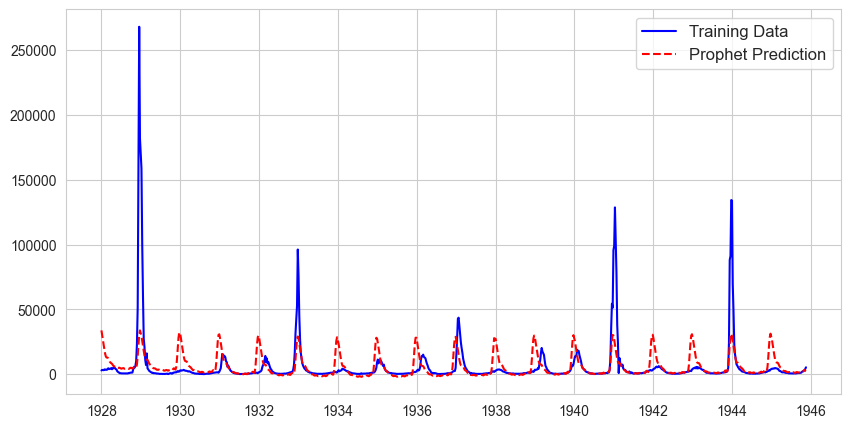

In [11]:
## We can plot the forecast by hand
plt.figure(figsize=(10,5))

plt.plot(flu_train.ds,
         flu_train.y,
         'b-',
         label="Training Data")

plt.plot(flu_train.ds,
         m.predict().yhat,
         'r--',
         label="Prophet Prediction")

plt.legend(fontsize=12)

plt.show()

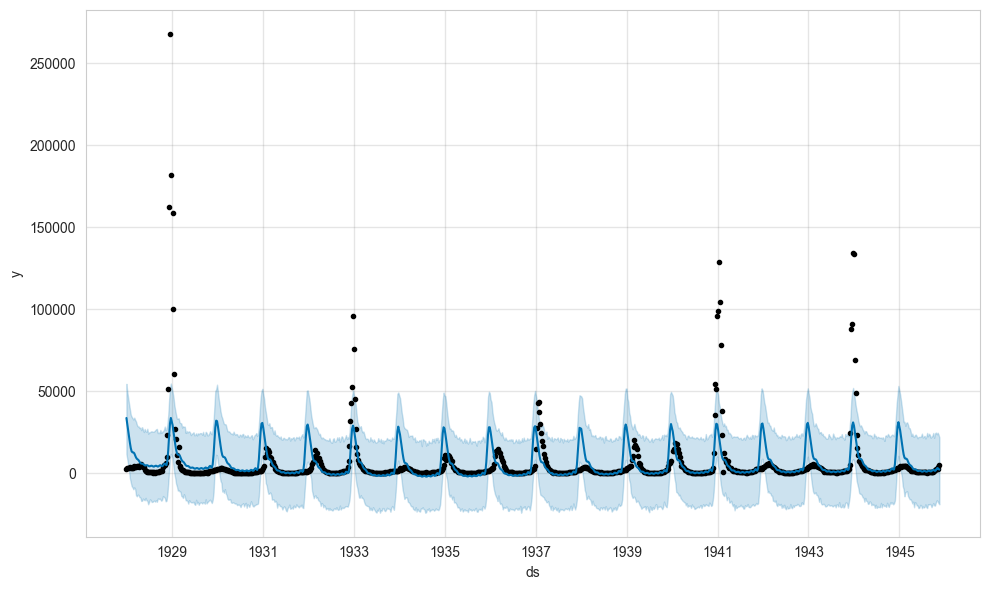

In [12]:
## or we can use prophet's built-in plotting functions
m.plot(forecast)

plt.show()

One nice feature of the prophet model is the forecast bounds. These give you a sense of what the model thinks is a reasonable range for forecast values. Again see the paper for details on how this range is generated.

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


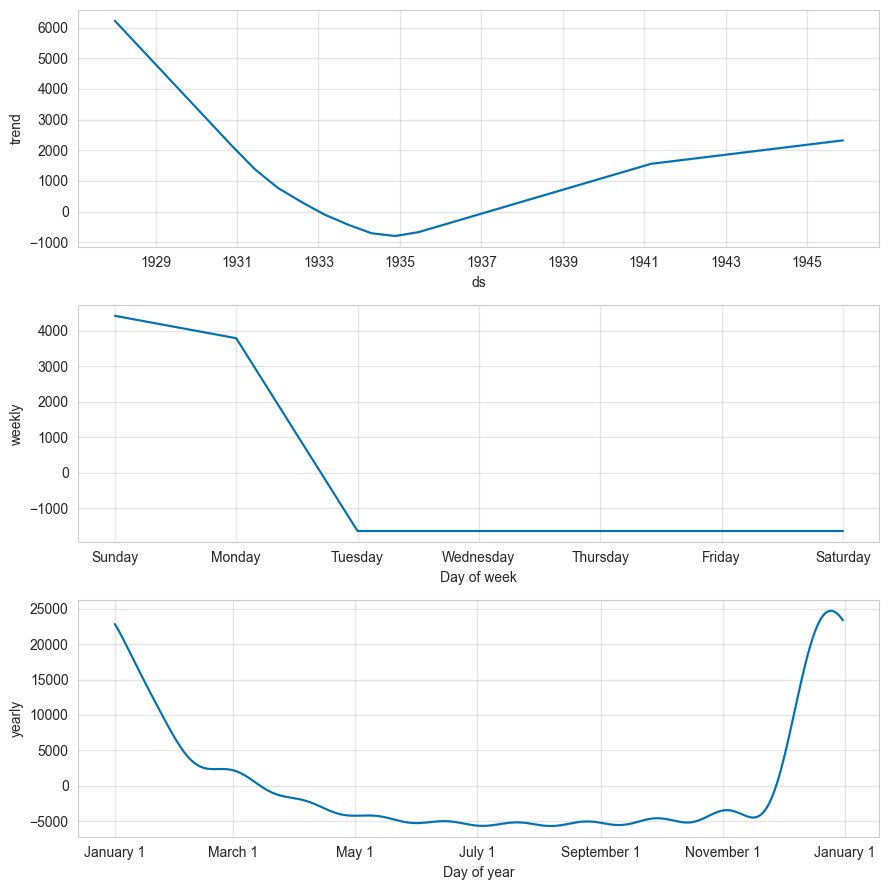

In [13]:
### We can also plot each of the components of the model separately
m.plot_components(forecast)

plt.show()

In [14]:
## You can make a forecast into the future
## by supplying .predict with a ds column of dates
## Note the double square brackets
m.predict(flu_test[['ds']])

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1945-11-25,2326.405634,-17340.189416,25658.510900,2326.405634,2326.405634,2504.793336,2504.793336,2504.793336,4428.240219,4428.240219,4428.240219,-1923.446883,-1923.446883,-1923.446883,0.0,0.0,0.0,4831.198969
1,1945-12-02,2329.516962,-9124.393597,33715.650809,2329.516962,2329.516962,8940.058856,8940.058856,8940.058856,4428.240219,4428.240219,4428.240219,4511.818637,4511.818637,4511.818637,0.0,0.0,0.0,11269.575818
2,1945-12-09,2332.628290,-573.761743,42143.353963,2332.628290,2332.628290,17761.603408,17761.603408,17761.603408,4428.240219,4428.240219,4428.240219,13333.363190,13333.363190,13333.363190,0.0,0.0,0.0,20094.231698
3,1945-12-16,2335.739618,6971.349266,47341.872983,2335.739618,2335.739618,25398.002977,25398.002977,25398.002977,4428.240219,4428.240219,4428.240219,20969.762759,20969.762759,20969.762759,0.0,0.0,0.0,27733.742595
4,1945-12-23,2338.850946,11666.220575,52404.541923,2338.850946,2338.850946,28961.289466,28961.289466,28961.289466,4428.240219,4428.240219,4428.240219,24533.049247,24533.049247,24533.049247,0.0,0.0,0.0,31300.140412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1947-11-30,2653.095076,-13078.814464,30625.046579,2392.958455,2919.224475,6221.731028,6221.731028,6221.731028,4428.240219,4428.240219,4428.240219,1793.490810,1793.490810,1793.490810,0.0,0.0,0.0,8874.826104
106,1947-12-07,2656.206404,-3306.169654,38404.048424,2389.896371,2924.594220,14546.890497,14546.890497,14546.890497,4428.240219,4428.240219,4428.240219,10118.650278,10118.650278,10118.650278,0.0,0.0,0.0,17203.096901
107,1947-12-14,2659.317732,4121.850235,47033.540885,2387.021282,2930.704173,23033.804717,23033.804717,23033.804717,4428.240219,4428.240219,4428.240219,18605.564498,18605.564498,18605.564498,0.0,0.0,0.0,25693.122449
108,1947-12-21,2662.429060,9722.227374,50715.614145,2385.020245,2936.814125,28235.629785,28235.629785,28235.629785,4428.240218,4428.240218,4428.240218,23807.389567,23807.389567,23807.389567,0.0,0.0,0.0,30898.058845


It is typically bad practice to use the default prophet model. We can make some quick adjustments for our particular problem:
- The default model is built to detect and fit daily, weekly, and yearly seasonality (this is known as mult-seasonality). However, this time series only exhibits yearly seasonality:
    - We can turn off daily seasonality fitting with `daily_seasonality=False`,
    - We can turn off weekly seasonality fitting with `weekly_seasonality=False`.
- I would argue that this time series exhibits no changepoints (in fact it exhibits no trend at all, but we are not able to turn off the trend component of the model):
    - We can set the number of changepoints to $0$ with `n_changepoints=0`.
    
Let's make those adjustments and then re-examine our model

In [15]:
## Making the model object
m = Prophet(weekly_seasonality=False,
            daily_seasonality=False,
            n_changepoints=0)

## Fitting the model, notice that we just input the df
## no .fit(X, y)
m.fit(flu_train)

Initial log joint probability = -4.208


/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      16       2125.78   0.000157935        26.418   3.966e-06       0.001       63  LS failed, Hessian reset 
      38       2125.83   2.36896e-05       20.1521      0.2248           1       96   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [16]:
forecast = m.predict()

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


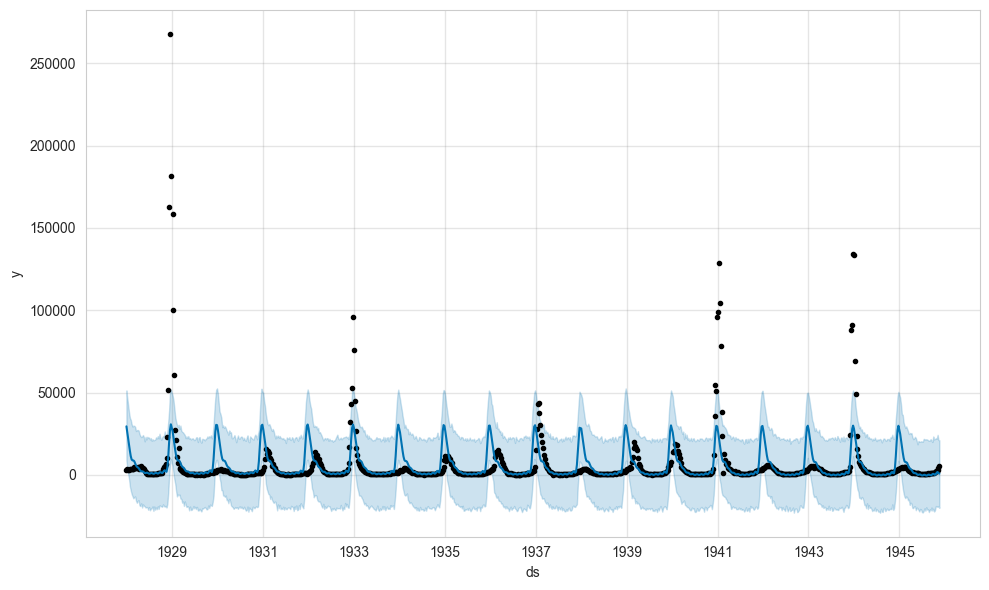

In [17]:
## or we can use prophet's built-in plotting functions
m.plot(forecast)

plt.show()

Not much of a noticeable difference, but our inputs are more appropriate for our data.

You may want to use other arguments like `changepoints`, `changepoint_range`, and `holidays`. Check out the `prophet` documentation to learn more about those, <a href="https://facebook.github.io/prophet/">https://facebook.github.io/prophet/</a>.

## Pitfalls

The authors tout that the prophet model works best with time series that have strong seasonal effects and several seasons of historical data. While this does capture a large class of time series data, not all data falls under this umbrella. It is important to keep in mind what a model works best for when applying it.

Perhaps infamously, the prophet model was associated with a huge forecasting failure for website Zillow, <a href="https://towardsdatascience.com/in-defense-of-zillows-besieged-data-scientists-e4c4f1cece3c">https://towardsdatascience.com/in-defense-of-zillows-besieged-data-scientists-e4c4f1cece3c</a>. To be fair to the data scientists working at Zillow at the time, the problem they were working on appeared to have very little room for error and it is likely that any model would have resulted in the same result. However, this case does highlight the importance of understanding the limitations of your models.

One difference between prophet and other forecasting models we have considered is that prophet is basically just fitting a curve to a series of points rather than fitting explicit statistical relationships. This approach can work well when your time series behaves similar to the past. A nice blog post on this aspect of prophet can be found here, <a href="https://www.sarem-seitz.com/facebook-prophet-covid-and-why-i-dont-trust-the-prophet/#takeaways-for-the-dedicated-prophet-user">https://www.sarem-seitz.com/facebook-prophet-covid-and-why-i-dont-trust-the-prophet/#takeaways-for-the-dedicated-prophet-user</a>. In this post the author suggests that prophet is a good model for detecting when your time series is exhibiting anomalous behavior.

## Summary

That being said, it is good to be familiar with prophet because it is used in industry settings. There may be times when prophet is the tool you want to use, and others where it is the tool you are told to use. Understanding how to apply it is critical in either.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)